<a href="https://colab.research.google.com/github/ShawnLiu119/Time-Series-SalesProj-ARIMA/blob/main/Sales_Projection_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/ShawnLiu119/Time-Series-SalesProj-ARIMA.git

Cloning into 'Time-Series-SalesProj-ARIMA'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [9]:
!cd /content/Time-Series-SalesProj-ARIMA

In [142]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 7.7 MB/s 
     |████████████████████████████████| 9.9 MB 24.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [35]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [36]:
#load the dataset

df = pd.read_csv('/content/Time-Series-SalesProj-ARIMA/Dataset- Superstore (2015-2018).csv')

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016/11/08,2016/11/11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016/11/08,2016/11/11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016/06/12,2016/06/16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015/10/11,2015/10/18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015/10/11,2015/10/18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [37]:
#data exploration

df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [38]:
## we will focus on forecast office supply category

df_os = df[df['Category'] == 'Office Supplies']

print('starting date is {}'.format(df_os['Order Date'].min()))
print('ending date is {}'.format(df_os['Order Date'].max()))
#There are 4 years data

starting date is 2014/01/03
ending date is 2017/12/30


####Data Preprocessing

removing unrelevant variables, handling missing data, aggregate sales by date. 
skip only two columns:Oder Date and Sales

In [41]:
df_os = df_os[['Order Date','Sales']]
df_os.head()

,Order Date,Sales
2,2016/06/12,14.620
4,2015/10/11,22.368
6,2014/06/09,7.280
8,2014/06/09,18.504
9,2014/06/09,114.900


In [42]:
## missing value
df_os.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [81]:
df_os_date = df_os.groupby(['Order Date']).sum().reset_index()
df_os_date.shape

(1148, 2)

In [82]:
df_os_date['Order Date'] = pd.to_datetime(df_os_date['Order Date'])  #need to convert 'str' index to 'datetime'index required by resample() -->timeseries practise
df_os_date = df_os_date.set_index(['Order Date'])

#### EDA

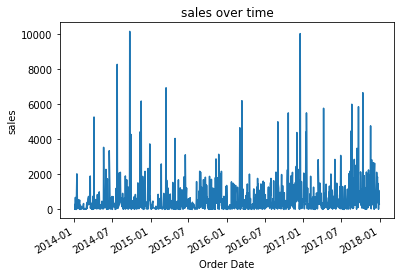

In [73]:
df_os_date['Sales'].plot()
plt.xlabel('Order Date')
plt.ylabel('sales')
plt.title('sales over time')
plt.show()

In [84]:
## can use monthly average sales to simplify the graph and see the pattern
#Convenience method for frequency conversion and resampling of time series. The object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex), or the caller must pass the label of a datetime-like series/index to the on/level keyword parameter.

# # resampling MS:
# date.resample('MS').mean()

# 2022-01-01    0.5
# 2022-02-01    2.0
# Freq: MS, dtype: float64

# # resampling M:
# date.resample('M').mean()
# 2022-01-31    0.5
# 2022-02-28    2.0
# Freq: M, dtype: float64


df_mon_os = pd.DataFrame()

df_mon_os['Sales'] = df_os_date['Sales'].resample('MS').mean()
df_mon_os.head()

,Sales
Order Date,
2014-01-01,285.357647
2014-02-01,63.042588
2014-03-01,391.176318
2014-04-01,464.794750
2014-05-01,324.346545


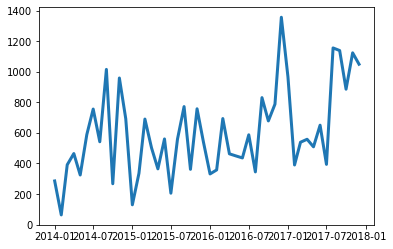

In [85]:
plt.plot(df_mon_os.index, df_mon_os['Sales'], linewidth=3 )

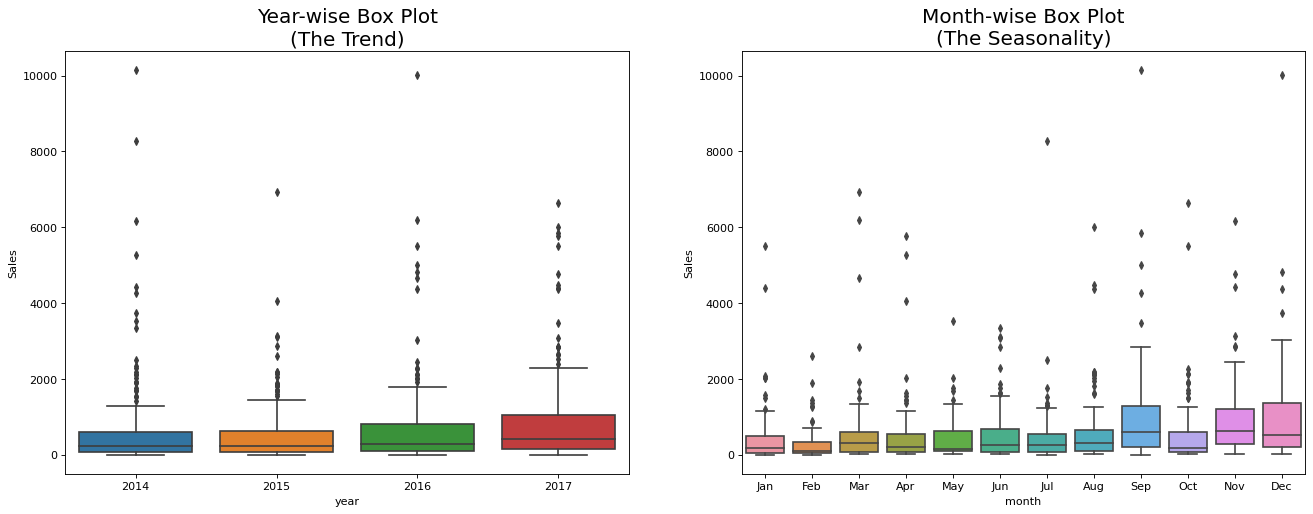

In [93]:
# We can nicely visualize the trend and how it varies each year in a nice year-wise boxplot.
# Likewise, we can do a month-wise boxplot to visualize the monthly distributions.
# Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

df_os_date['year'] = [d.year for d in df_os_date.index]
df_os_date['month'] = [d.strftime('%b') for d in df_os_date.index] #%b ---> Month as locale’s abbreviated name.

fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
sns.boxplot(x='year', y='Sales', data=df_os_date, ax=axes[0])
sns.boxplot(x='month', y='Sales', data=df_os_date, ax=axes[1])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [95]:
df_os_date.head()

,Sales,year,month
Order Date,,,
2014-01-03,16.448,2014,Jan
2014-01-04,288.060,2014,Jan
2014-01-05,19.536,2014,Jan
2014-01-06,685.340,2014,Jan
2014-01-07,10.430,2014,Jan


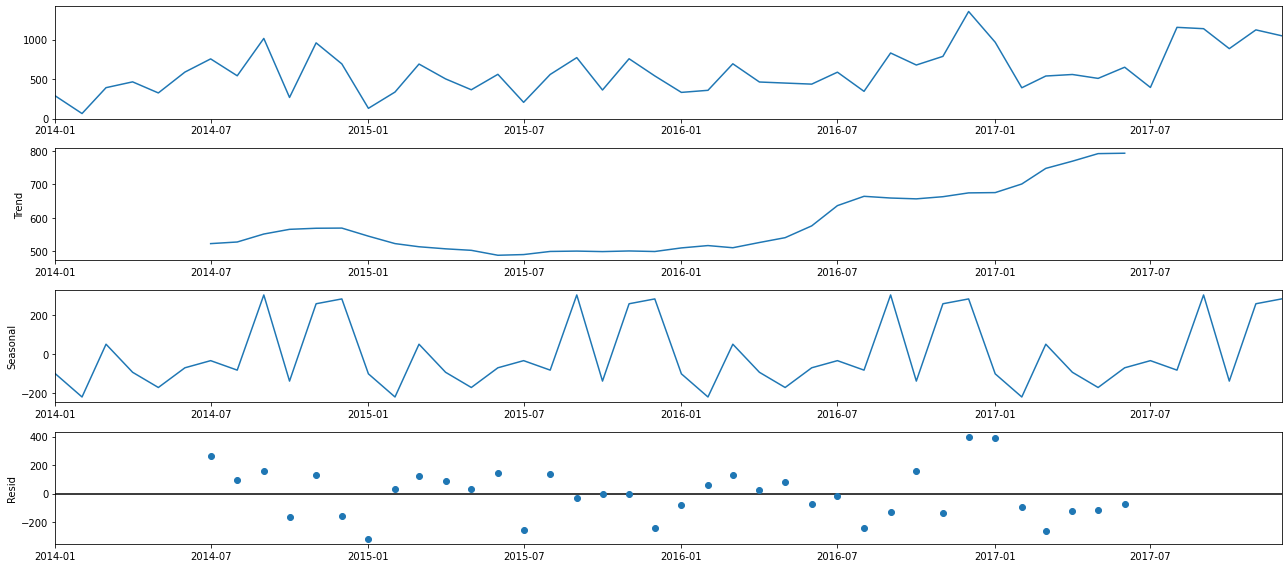

In [100]:
from pylab import rcParams #customize pyplotlib
rcParams['figure.figsize'] = 18, 8


#need to convert time series to specified frequency --> df.asfreq
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html
#df_mon_os.asfreq('MS')

decomposition = sm.tsa.seasonal_decompose(df_mon_os.asfreq('MS'), model='additive') #sm.tsa --> time series analysis package
fig = decomposition.plot()
plt.show()

####Stationary Check

Plotting Rolling Statistic: we can plot the moving average or moving variance and see if it varies with time.

Dickey- Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

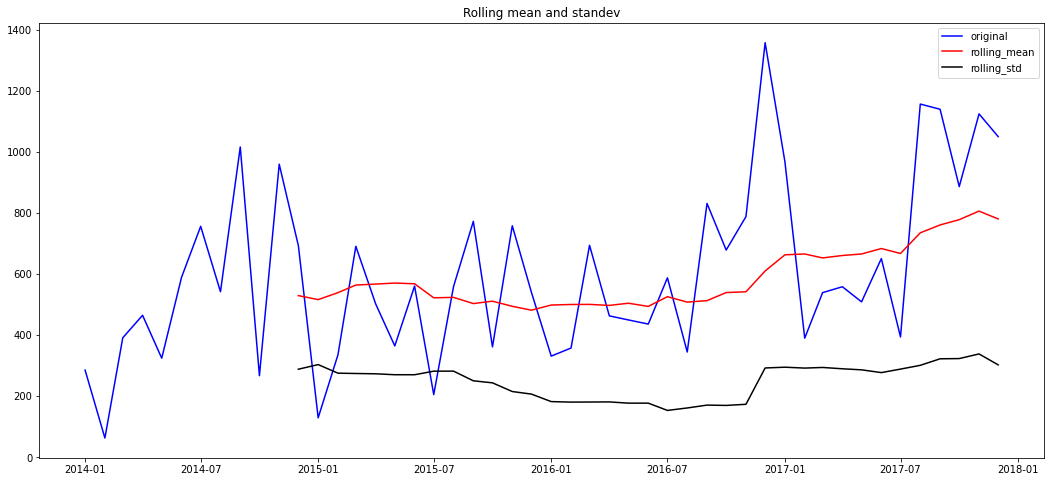

In [102]:
##plot the rolling statistics

moving_avg = df_mon_os.rolling(12).mean()
moving_std = df_mon_os.rolling(12).std() #still the same length of periods, but the first cycle will be all 'NaN' value

orig = plt.plot(df_mon_os, color='blue', label ='original')
ma = plt.plot(moving_avg, color='red', label = 'rolling_mean')
mstd = plt.plot(moving_std, color='black', label = 'rolling_std')
plt.legend(loc='best')
plt.title('Rolling mean and standev')
plt.show()

ADF Test Hypothesis

Null Hypothesis (HO): Series is non-stationary or series has a unit root.

Alternate Hypothesis(HA): Series is stationary or series has no unit root.

In [108]:
#we can tell the mean and std is not constant across time period

#Dickey Fuller test
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df_mon_os, autolag='AIC')
print(dftest)

#denote the output of adfuller test with explanation
dfoutput = pd.Series(dftest[0:4], index=['Test_Statistic', 'p-value', '#lags_User', 'Number_of_observation'])

for key, value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

(-4.664633175077929, 9.801371572373145e-05, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 520.2817884281114)
Test_Statistic           -4.664633
p-value                   0.000098
#lags_User                0.000000
Number_of_observation    47.000000
Critical Value (1%)      -3.577848
Critical Value (5%)      -2.925338
Critical Value (10%)     -2.600774
dtype: float64


In [111]:
#p value represeents:  Probability that null hypothesis will not be rejected(p-value)

#since p-value is < 0.05, the null hypothesis could be rejected, that means data is stationary....

# The ADF test is not a test of nonstationarity in general, but of a very specific kind of nonstationarity, namely, presence of a unit root. 
# Thus it cannot indicate stationarity in general, only lack of a unit root.


KPSS Test

Null Hypothesis (HO): Series is trend stationary or series has no unit root.

Alternate Hypothesis(HA): Series is non-stationary or series has a unit root.


In [110]:
#hence, we use KPSS test

from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)


kpss_test(df_mon_os)
#p value < 0.05, so reject the null hypothesis --> data is non stationary (case 4, difference stationary)

Results of KPSS Test:
Test Statistic           0.594920
p-value                  0.023098
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [112]:
# When to choose ADF or KPSS test?

# There could be a lot of confusion on when should one use the ADF test or KPSS test and which test would give a correct result.
# A better solution is to apply/run both the tests and makes sure that the series is truly stationary.
# The following are the possible outcomes of applying both the tests.
# Case 1: Both tests conclude that the given series is stationary – The series is stationary
# Case 2: Both tests conclude that the given series is non-stationary – The series is non-stationary
# Case 3: ADF concludes non-stationary and KPSS concludes stationary – The series is trend stationary. To make the series strictly stationary, the trend needs to be removed in this case. Then the detrended series is checked for stationarity.
# Case 4: ADF concludes stationary and KPSS concludes non-stationary – The series is difference stationary. Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

####Stationary Transformaion

*   log ---> np.log(df)
*   moving avergage ----> y.rolling(12).mean()
*   exponential weight moving average ---->y.ewm(halflife=12).mean()
*   differencing ----y.shift(period=1)
*   decomposition



In [118]:
df_os_log = df_os.copy().groupby(['Order Date']).sum().reset_index()
df_os_log = df_os_log.set_index('Order Date')

df_os_log.index = pd.to_datetime(df_os_log.index)

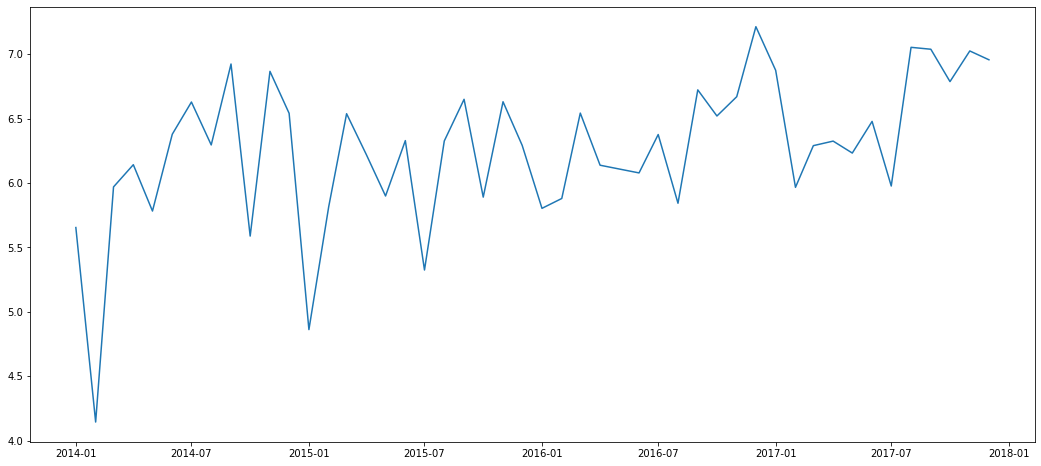

In [120]:
y = df_os_log['Sales'].resample('MS').mean() 
#resample ---> Convenience method for frequency conversion and resampling of time series. 

y_log = np.log(y)
plt.plot(y_log)

#we can see implment a log transformation does not solve the stationary problem

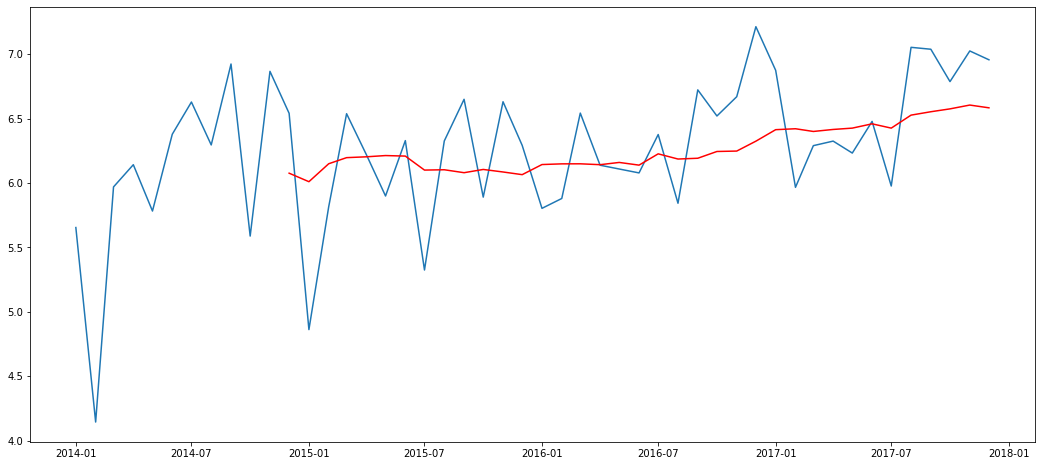

In [121]:
#moving average ---> moving average actually has taken into account the trend of the data, so we will test stationary based on
#the difference between data and moving average ---> diff

moving_avg = y_log.rolling(12).mean()

plt.plot(y_log)
plt.plot(moving_avg, color = 'red')
# this still does not solve the problem

In [131]:
def test_stationary(data):
  rolmean = data.rolling(12).mean()
  rolstd = data.rolling(12).std()

  orig = plt.plot(data, color='blue', label ='original')
  ma = plt.plot(rolmean, color='red', label = 'rolling_mean')
  mstd = plt.plot(rolstd, color='black', label = 'rolling_std')
  plt.legend(loc='best')
  plt.title('Rolling mean and standev')
  plt.show()

  dftest = adfuller(data, autolag = 'AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  
  print("test output from ADF test:")
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

  print("test output from ADF test:")
  kpss_test(data)

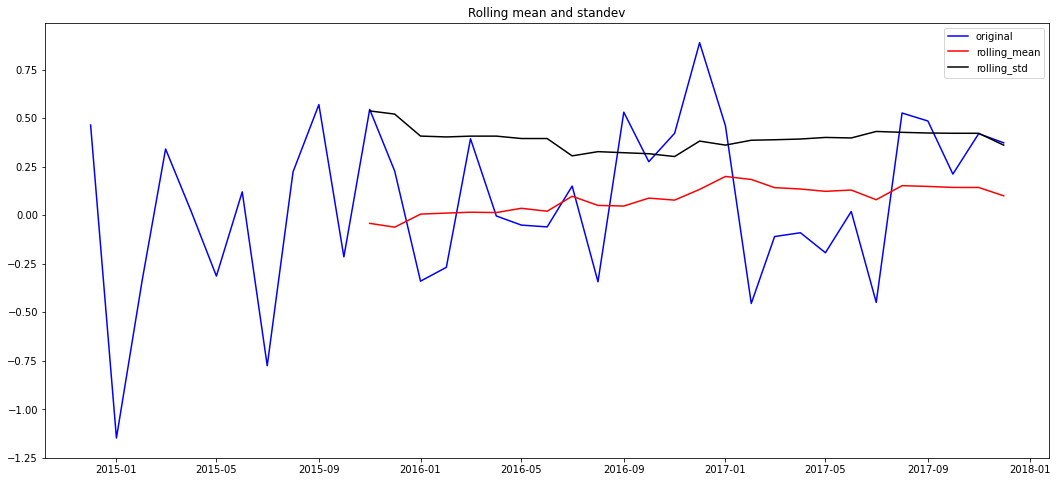

test output from ADF test:
Test Statistic                 -5.626996
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64
test output from ADF test:
Results of KPSS Test:
Test Statistic           0.275008
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [132]:
y_log_m_diff = y_log - moving_avg
y_log_m_diff.dropna(inplace=True)

test_stationary(y_log_m_diff)
#ahtought Kpss has 10% p value, its nulll hypothesis is the flip, so its null assume data stationary

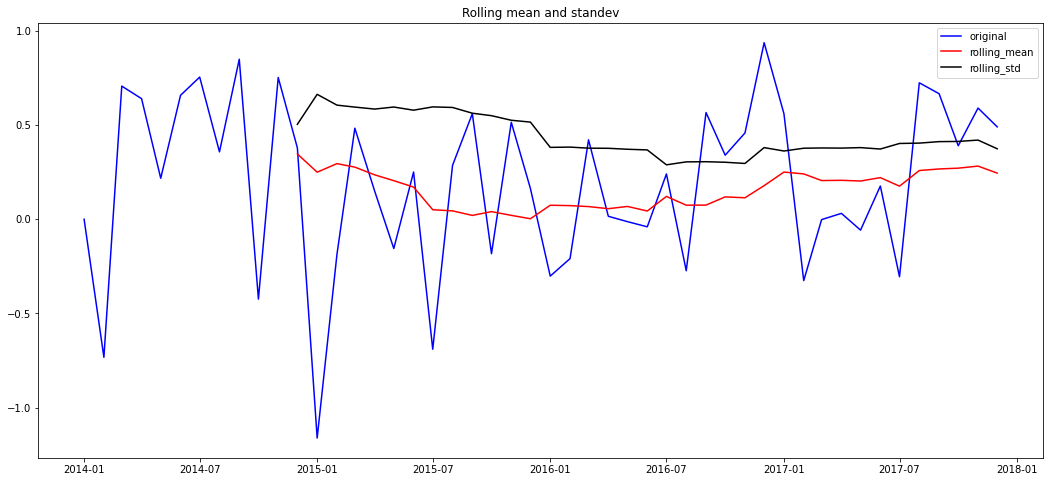

test output from ADF test:
Test Statistic                 -2.967356
p-value                         0.038057
#Lags Used                      3.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64
test output from ADF test:
Results of KPSS Test:
Test Statistic           0.118928
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [133]:
#p value has been greatly reduced -- good 

expo_ma = y_log.ewm(halflife=12).mean()
#A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.
#eighted moving average’ where more recent values are given a higher weight.

expo_ma_diff = y_log - expo_ma
test_stationary(expo_ma_diff)

#the data achive stationary

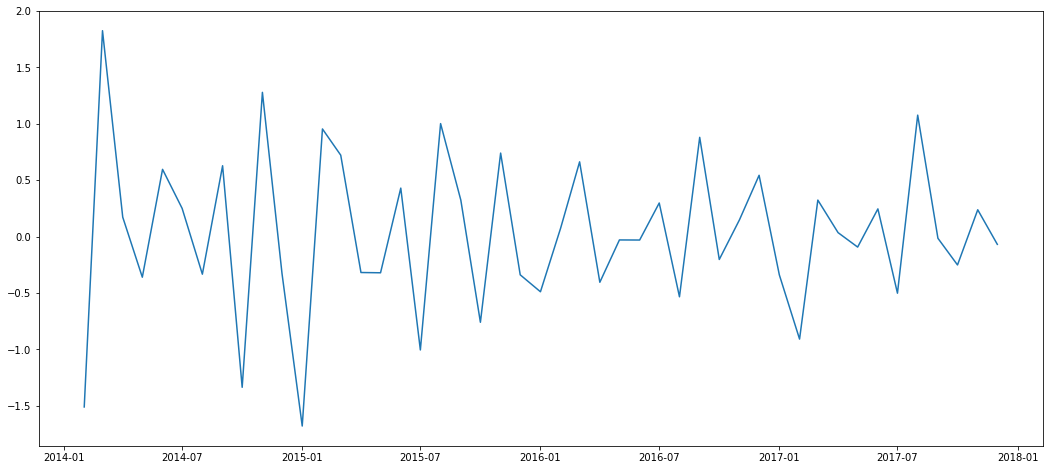

In [127]:
#differencing

y_log_diff = y_log - y_log.shift()
plt.plot(y_log_diff)

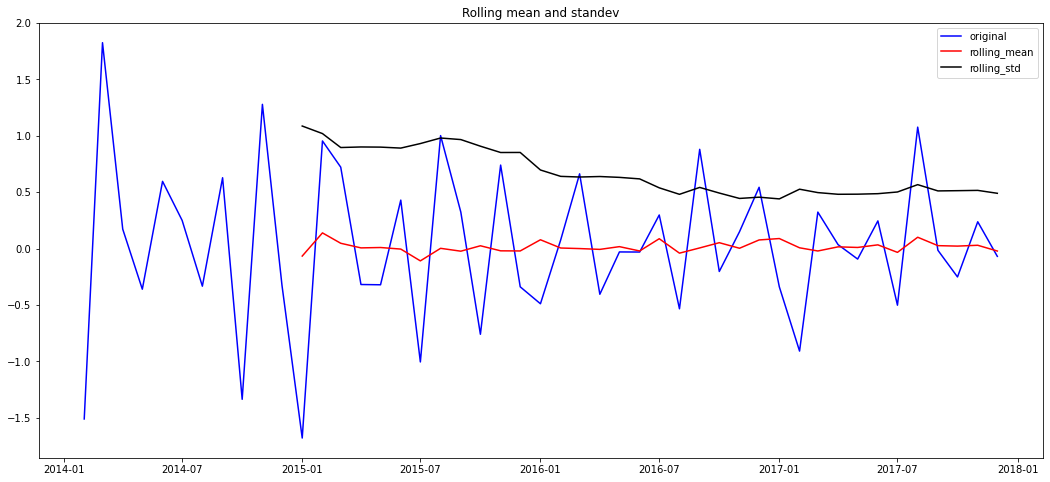

test output from ADF test:
Test Statistic                 -4.771865
p-value                         0.000062
#Lags Used                      9.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64
test output from ADF test:
Results of KPSS Test:
Test Statistic            0.145024
p-value                   0.100000
#Lags Used               13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [134]:
y_log_diff.dropna(inplace=True)
test_stationary(y_log_diff)

#basically achieveed stationary

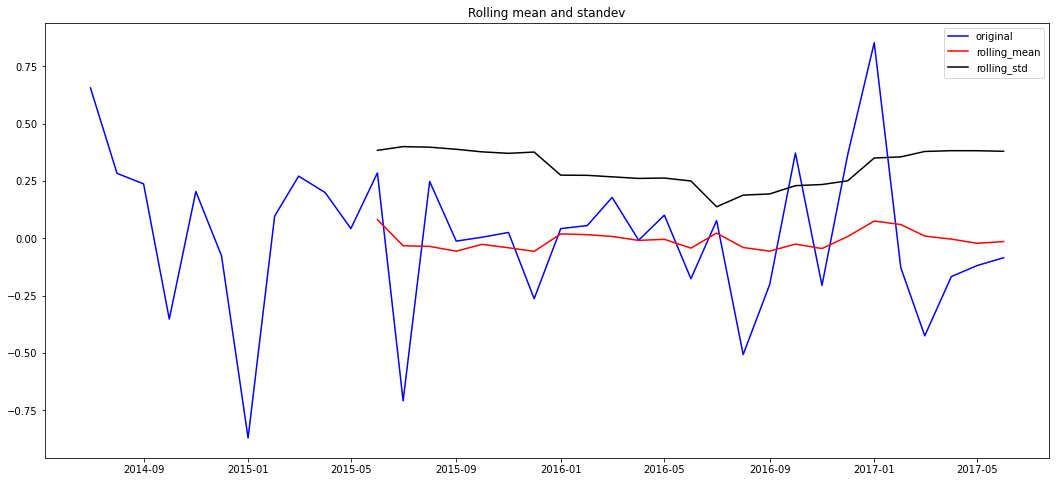

test output from ADF test:
Test Statistic                 -4.901459
p-value                         0.000035
#Lags Used                      4.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64
test output from ADF test:
Results of KPSS Test:
Test Statistic           0.083999
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [135]:
#decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y_log)

residual = decomposition.resid
season_component = decomposition.seasonal
trend_component = decomposition.trend

y_log_decompose = residual
y_log_decompose.dropna(inplace=True)
test_stationary(y_log_decompose)
#using residual after decomposition can also achieve stionary

####Forecasting Model - ARIMA

- ACF and PACF plot

- Auto_arima

- Loops

In [139]:
#The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

# Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable.
# Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation.
# Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

In [141]:
#train_test_split

y_train = y[:40]
y_test = y[40:]

In [143]:
import pmdarima
from pmdarima import auto_arima

In [144]:
auto_arima(y_train, test='adf', seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

# m : int, optional (default=1) The period for seasonal differencing, m refers to the number of periods in each season. For example, m is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data. Default is 1. Note that if m == 1 (i.e., is non-seasonal), seasonal will be set to False. For more information on setting this parameter, see Setting m.
# seasonal : bool, optional (default=True) Whether to fit a seasonal ARIMA. Default is True. Note that if seasonal is True and m == 1, seasonal will be set to False.
# test : str, optional (default=’kpss’) Type of unit root test to use in order to detect stationarity if stationary is False and d is None. Default is ‘kpss’ (Kwiatkowski–Phillips–Schmidt–Shin).

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=592.497, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=576.965, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=559.020, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=554.143, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=555.183, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=555.965, Time=0.12 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.287 seconds


ARIMA(order=(3, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [146]:
auto_arima(y, seasonal=True, stepwise=True, trace=True, error_action='ignore')

#the lowest AIC should be picked
#You are testing via AIC (Akaike Information Criterion) and the lowest AIC is the best model for automated model selection

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=682.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=673.518, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=680.349, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=666.940, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=668.928, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=668.928, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=670.928, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=665.748, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=671.902, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=667.718, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=667.709, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=666.599, Time=0.0

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [148]:
from statsmodels.tsa.arima.model import ARIMA
model_1=ARIMA(y_train, order=(3,2,0)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   40
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -273.072
Date:                Fri, 02 Dec 2022   AIC                            554.143
Time:                        03:43:31   BIC                            560.694
Sample:                    01-01-2014   HQIC                           556.474
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2813      0.145     -8.820      0.000      -1.566      -0.997
ar.L2         -1.0849      0.203     -5.337      0.000      -1.483      -0.687
ar.L3         -0.4191      0.158     -2.649      0.008      -0.729      -0.109
sigma2      9.819e+04    2.2e+04      4.460      0.000     5.5e+04    1.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.60   Prob(JB):                         0.39
Heteroskedasticity (H):               0.94   Skew:                            -0.55
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
model_2=ARIMA(y_train, order=(2,1,0)).fit()
model_2.summary()

#No2 model has slight lower AIC score

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   40
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -273.480
Date:                Fri, 02 Dec 2022   AIC                            552.961
Time:                        03:44:19   BIC                            557.951
Sample:                    01-01-2014   HQIC                           554.751
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6392      0.145     -4.398      0.000      -0.924      -0.354
ar.L2         -0.4178      0.150     -2.777      0.005      -0.713      -0.123
sigma2      7.116e+04   1.94e+04      3.673      0.000    3.32e+04    1.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.89   Prob(JB):                         0.75
Heteroskedasticity (H):               0.97   Skew:                            -0.23
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
model_3=ARIMA(y_train, order=(1,1,1)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   40
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -273.088
Date:                Fri, 02 Dec 2022   AIC                            552.176
Time:                        03:48:23   BIC                            557.167
Sample:                    01-01-2014   HQIC                           553.967
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1424      0.249      0.573      0.567      -0.345       0.630
ma.L1         -0.9118      0.143     -6.398      0.000      -1.191      -0.632
sigma2      6.796e+04   1.48e+04      4.607      0.000     3.9e+04    9.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.60   Prob(JB):                         0.51
Heteroskedasticity (H):               0.84   Skew:                             0.45
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
pred_1= model_1.predict(start=len(y_train), end=(len(y)-1),dynamic=True)
pred_1

2017-05-01     34.292602
2017-06-01     42.825453
2017-07-01     12.888972
2017-08-01   -317.799151
2017-09-01   -444.545132
2017-10-01   -490.173534
2017-11-01   -734.968271
2017-12-01   -898.051351
Freq: MS, Name: predicted_mean, dtype: float64

In [154]:
pred_2= model_2.predict(start=len(y_train), end=(len(y)-1),dynamic=True)
pred_3= model_3.predict(start=len(y_train), end=(len(y)-1),dynamic=True)

####Model Evaluation Performance

Mean Absolute Percentage Error (MAPE): MAPE is defined as the percentage of the average of absolute difference between forecasted values and true values, divided by true value.

<BarContainer object of 3 artists>

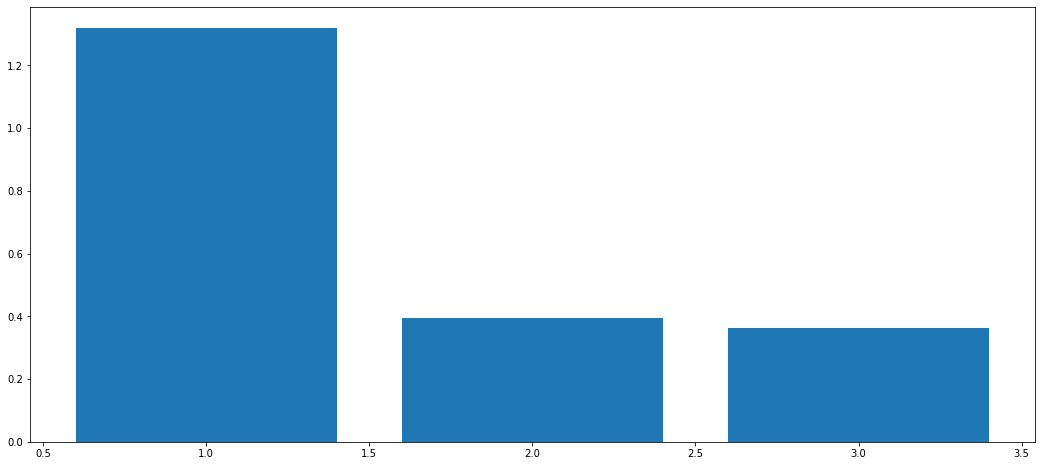

In [164]:
from  sklearn.metrics import mean_absolute_percentage_error

mape_1= mean_absolute_percentage_error(y_test, pred_1)
mape_2= mean_absolute_percentage_error(y_test, pred_2)
mape_3= mean_absolute_percentage_error(y_test, pred_3)

result= [mape_1, mape_2, mape_3]
print(result)